In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
flood_data = pd.read_csv('aegis_flood_data/AEGISDataset.csv')

In [3]:
flood_data.info()
flood_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         3510 non-null   float64
 1   lon         3510 non-null   float64
 2   flood_heig  3510 non-null   int64  
 3   elevation   3510 non-null   float64
 4   precipitat  3510 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 137.2 KB


,lat,lon,flood_heig,elevation,precipitat
0,14.640394,121.055708,0,54.553295,9.0
1,14.698299,121.002132,0,21.856272,10.0
2,14.698858,121.100261,0,69.322807,16.0
3,14.571310,120.983334,0,10.987241,8.0
4,14.762232,121.075735,0,87.889847,18.0


In [4]:
# reclassify data
flood_data['is_flooding'] = flood_data['flood_heig'].apply(lambda x: 0 if x <= 1 else 1)

In [5]:
flood_data.head()

,lat,lon,flood_heig,elevation,precipitat,is_flooding
0,14.640394,121.055708,0,54.553295,9.0,0
1,14.698299,121.002132,0,21.856272,10.0,0
2,14.698858,121.100261,0,69.322807,16.0,0
3,14.571310,120.983334,0,10.987241,8.0,0
4,14.762232,121.075735,0,87.889847,18.0,0


In [6]:
flood_data['is_flooding'].value_counts()

is_flooding
1    2316
0    1194
Name: count, dtype: int64

In [7]:
flood_data['precipitat'].unique()

array([ 9., 10., 16.,  8., 18., 11., 12., 13., 17., 15., 14.,  6.,  7.,
        0., 19., 21., 20.,  5.])

## Plotting Data

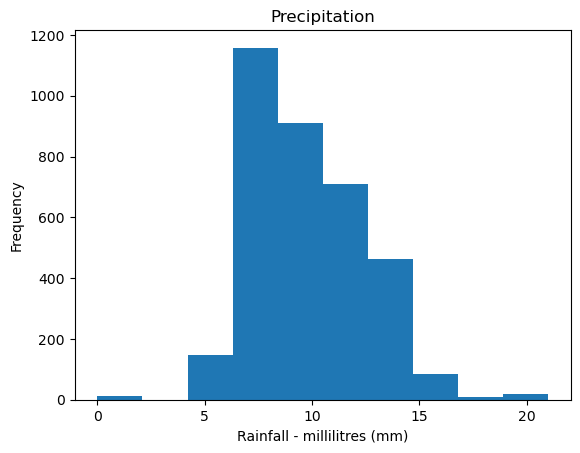

In [35]:
# plotting the distribution of precipitation column
ax = flood_data['precipitat'].hist(grid=False, bins=10)
ax.set_xlabel('Rainfall - millilitres (mm)')
ax.set_ylabel('Frequency')
ax.set_title('Precipitation');

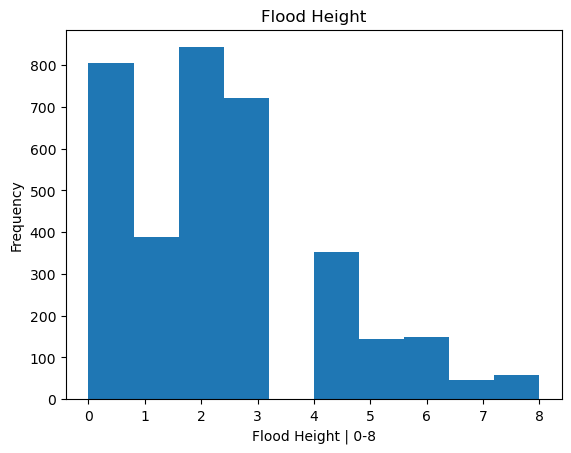

In [36]:
# plotting the distribution of precipitation column
ax = flood_data['flood_heig'].hist(grid=False, bins=10)
ax.set_xlabel('Flood Height | 0-8')
ax.set_ylabel('Frequency')
ax.set_title('Flood Height');

#### Plotting Data Imbalance

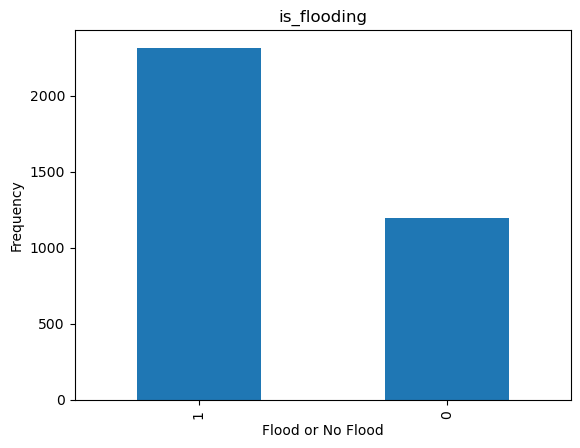

In [41]:
ax = flood_data['is_flooding'].value_counts().plot(kind='bar')
ax.set_xlabel('Flood or No Flood')
ax.set_ylabel('Frequency')
ax.set_title('is_flooding');

### Using Folium

In [7]:
import folium

In [17]:
m = folium.Map(location=[14.599512, 121.023415], zoom_start=11)
m

In [20]:
for _, row in flood_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
    ).add_to(m)

In [21]:
m

### Using Contextily

In [8]:
import geopandas as gpd
import contextily as cx

In [9]:
gdf = gpd.GeoDataFrame(flood_data, geometry=gpd.points_from_xy(flood_data['lon'], flood_data['lat']))

In [10]:
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

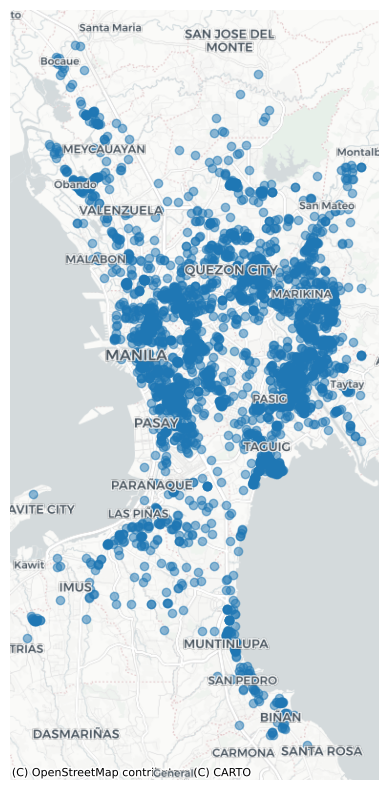

In [11]:
# Plot the data
ax = gdf.plot(figsize=(10, 10), alpha=0.5)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

In [ ]:
from shapely.geometry import Polygon
import numpy as np

def create_grid(gdf, cell_size):
    xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounds of the points
    cols = np.arange(xmin, xmax, cell_size)
    rows = np.arange(ymin, ymax, cell_size)
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append(Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]))
    grid = gpd.GeoDataFrame({'geometry': polygons})
    return grid

# Example: create a grid with cell size 0.1 units (adjust as needed)
grid_gdf = create_grid(gdf, 0.1)

In [16]:
# Spatial join to assign points to grid cells
joined_gdf = gpd.sjoin(gdf, grid_gdf, how="left", op="within")

# Count the number of points in each grid cell
aggregated_grid = joined_gdf.groupby('index_right').size().reset_index(name='point_count')

# Merge the counts with the grid
grid_with_data = grid_gdf.merge(aggregated_grid, left_index=True, right_on='index_right', how='left')

# Replace NaN values with 0 for polygons with no points
grid_with_data['point_count'].fillna(0, inplace=True)

NameError: name 'grid_gdf' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot the grid with the point density as a choropleth
grid_with_data.plot(column='point_count', cmap='OrRd', legend=True)

# Display the plot
plt.show()

### Class == 1 (Flooded)

In [6]:
flood_data_flood = flood_data[flood_data['is_flooding'] == 1]
flood_data_no_flood = flood_data[flood_data['is_flooding'] == 0]

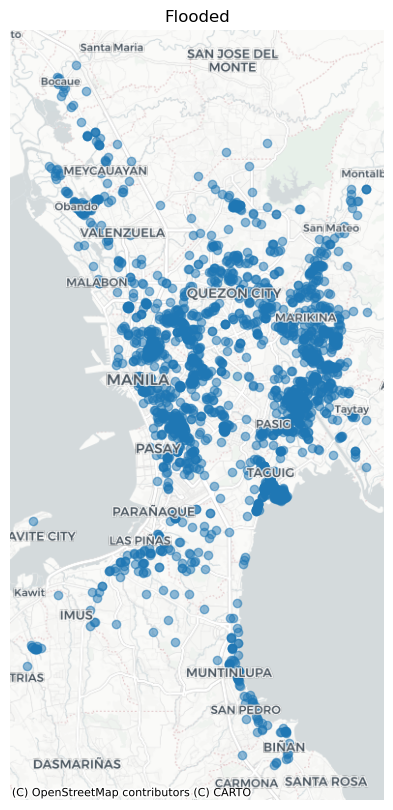

In [22]:
# plot flooded
data = flood_data_flood
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['lon'], data['lat']))
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10, 10), alpha=0.5)
ax.set_title('Flooded')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

### Class == 0 (No Flood)

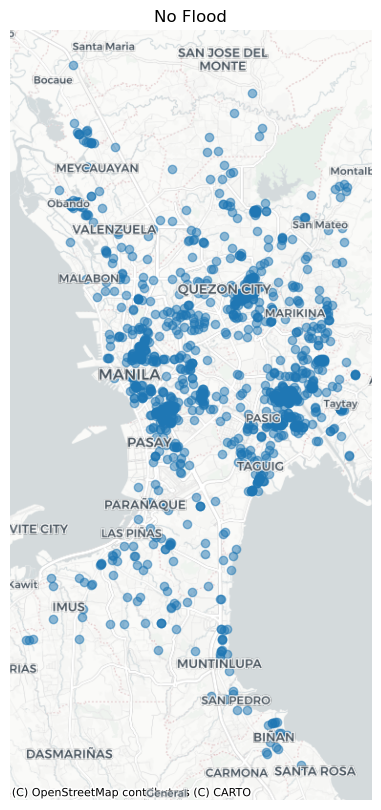

In [19]:
# plot no flood
data = flood_data_no_flood
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['lon'], data['lat']))
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)
ax = (gdf.plot(figsize=(10, 10), alpha=0.5))
ax.set_title('No Flood')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

Creating cloropeth map.

Now, let's perform a spatial join of the flood landscape data with the flood hazard map.

In [ ]:
# import map
flood_hazard_map = pd.read_file('noah_data/5yr/MetroManila5yr.zip', crs='EPSG:32633')
# let's convert to lon lat instead of easting and northing
flood_hazard_map_wgs84 = flood_hazard_map.to_crs(epsg=4326)

Now, since we have the data, let's fit a spatial regression model to our data.